Today we will build a class that allows us to better organize our SQL queries and visualization code. 

To begin let's review some SQL. 

In [80]:
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt

# For testing code
from test_scripts.test_class import Test
test = Test()

In [81]:
path = os.path.join('data', 'chinook.db')
conn = sqlite3.connect(path)
cursor = conn.cursor()

![schema](images/schema.png)

### TASK 1

In the cell below, write code that generates a list containing the names of all tables in the chinook database. 

In [82]:
tables = cursor.execute('''SELECT name FROM sqlite_master
                                        WHERE
                                        type = 'table'
                                        AND
                                        name NOT LIKE 'sqlite_%';''').fetchall()

tables = [table[0] for table in tables]
tables

['albums',
 'artists',
 'customers',
 'employees',
 'genres',
 'invoices',
 'invoice_items',
 'media_types',
 'playlists',
 'playlist_track',
 'tracks']

In [83]:
test.run_test(tables, 'tables')

✅ **Hey, you did it.  Good job.**

### TASK 2

In the cell below, write code that will generate a dataframe of yearly revenue. The dataframe should be sorted by year. 

In [84]:
q = f"""select strftime('%Y', invoicedate) as "year", SUM(unitprice * quantity) as amount
       FROM invoices
       INNER JOIN invoice_items
       USING(invoiceid)
       GROUP BY year
       ORDER BY year;"""

pd.read_sql(q, conn)

,year,amount
0,2009,449.46
1,2010,481.45
2,2011,469.58
3,2012,477.53
4,2013,450.58


In [85]:
test.run_test(pd.read_sql(q, conn), 'yearly_revenue')

✅ **Hey, you did it.  Good job.**

### TASK 3

In the cell below, write code to generate a dataframe that counts the numbers of artists that are found within each genre. Sort the dataframe in ascending order.

In [86]:
q = """select count(distinct al.artistid) as "count",
      g.name as "name"
       FROM albums al
       INNER JOIN tracks
       USING(albumid)
       INNER JOIN genres g
       USING(genreid)
       GROUP BY g.name
       ORDER BY "count";
      """
pd.read_sql(q, conn).sort_values('count')

,count,name
0,1,Bossa Nova
1,1,Comedy
2,1,Easy Listening
3,1,Heavy Metal
4,1,Opera
5,1,Rock And Roll
6,1,Science Fiction
7,2,Drama
8,2,Hip Hop/Rap
9,2,Sci Fi & Fantasy


In [87]:
test.run_test(pd.read_sql(q, conn).sort_values('count'), 'artists_per_genre')

✅ **Hey, you did it.  Good job.**

# OOP

Let's begin by building a quick `Example` class, and break down some of the elements.

In [88]:
class Example:
    attribute = "I'm an attribute!"
    
    def method(self):
        return "I'm a method!"

In [89]:
Example.attribute

"I'm an attribute!"

In [90]:
Example.method()

TypeError: method() missing 1 required positional argument: 'self'

In [91]:
Example.method(Example)

"I'm a method!"

### Adding an `__init__` method

> [A good thread on the init method](https://stackoverflow.com/questions/625083/what-init-and-self-do-in-python)

The init method activates when we create an *instance* of the class. 

In [92]:
class Example:
    attribute = "I'm an attribute!"
    
    # Adding an init method
    def __init__(self): 
        self.instance_attribute = "I'm an instance attribute!"
        # You'll notice that self is used to create this attribute. 
        # Whenever we create an instance attribute, we
        # have to use self.
    
    def method(self):
        return "I'm a method!"

**Creating an instance**

In [93]:
instance = Example()

In [94]:
instance.instance_attribute

"I'm an instance attribute!"

**The init method is especially helpful when we need to pass object to our class**

In [95]:
class Example:
    attribute = "I'm an attribute!"
    
    # We have updated the __init__ method
    # so it also receives a number
    def __init__(self, number):
        self.instance_attribute = "I'm an instance attribute!"
        # We then create an attribute that
        # adds three to the received number
        self.add_three = number + 3
    
    def method(self):
        return "I'm a method!"

**Now if try to create an instance of the class like we did before...**

In [96]:
instance = Example()

TypeError: __init__() missing 1 required positional argument: 'number'

**...we receive an error message because the init method did not receive a required argument.**

To provide arguments to the init method, we pass the argument into the parentheses used to call the class. 

In [97]:
instance = Example(3)

In [98]:
instance.add_three

6

**Using an attribute inside a method**

It is common when writing code to have global variables that must be passed into a function, or used inside a function. 

This can be a bit annoying since the main reason we create functions is so we do not have to keep typing the same things over and over again. 

Classes can be used to solve this problem!

In [99]:
class Greeting:
    
    def __init__(self, greeting=None):
        if not greeting:
            greeting = "It's nice to meet you!"
        self.greeting = greeting
        
    def message(self, name):
        return f"Hi, {name}!" + ' ' + self.greeting

In [100]:
greeting, name = ("Can you please do the dishes?", 'Joel')

whats_up = Greeting(greeting)

whats_up.message(name)

'Hi, Joel! Can you please do the dishes?'

# Code Assignment

Let's take the sql queries we wrote above and create a `Queries` class. 

This class should have attributes for the connection to the database, and individual methods for each query. 

The output for each query method should look exactly like the outputs for our sql queries aboves.

In [101]:
class Queries:
    def __init__(self, database_path):
        self.conn = sqlite3.connect(database_path)
        self.cursor = self.conn.cursor()

#=============== HELPER FUNCTIONS ===============

    def query(self, q):
        return pd.read_sql(q, self.conn)
    
#=================== QUERIES ====================
 
    def table_names(self):
        q = '''SELECT name FROM sqlite_master
                WHERE
                type = 'table'
                AND
                name NOT LIKE 'sqlite_%';'''
        tables = self.cursor.execute(q).fetchall()
        return  [x[0] for x in tables]
        
    
    def artists_per_genre(self):
        q = """select count(distinct al.artistid) as "count",
              g.name as "name"
               FROM albums al
               INNER JOIN tracks
               USING(albumid)
               INNER JOIN genres g
               USING(genreid)
               GROUP BY g.name
              """
        return self.query(q)
        
    def yearly_revenue(self):
        q = f"""select strftime('%Y', invoicedate) as "year", SUM(unitprice * quantity) as amount
               FROM invoices
               INNER JOIN invoice_items
               USING(invoiceid)
               GROUP BY year
               ORDER BY year;"""

        return self.query(q)


**Let's test our work**

In [102]:
queries = Queries(path)
test.run_test(queries.table_names(), 'class_table_names')
test.run_test(queries.artists_per_genre(), 'class_artists')
test.run_test(queries.yearly_revenue(), 'class_revenue')

✅ **Hey, you did it.  Good job.**

✅ **Hey, you did it.  Good job.**

✅ **Hey, you did it.  Good job.**

### Inheritance 

Classes can inherit code from other classes! This can be a bit confusing at first, but this is where the magic of OOP programming really kicks in. 

In [103]:
class Arrays:
    def __init__(self):
        self.x = [1,2,3]
        self.y = [3,2,1]
       
# This is where the inheritance takes place
class Visualize(Arrays):
    def line(self):
        plt.plot(self.x, self.y)

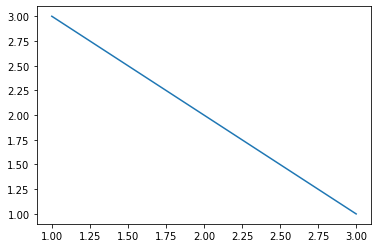

In [104]:
viz = Visualize()
viz.line()

We can also make classes that serve as a subclass

In [105]:
class User:
    def __init__(self, username, secret_key):
        User.key = secret_key
        User.name = username
        self.sub = Authorize()
    
class Authorize:
    def __init__(self):
        self.key = User.key
        self.user = User.name
        
    def check_password(self):
        if self.user == 'Joel' and self.key == 'secret_key':
            print('Password correct!')
        else:
            print('Incorrect Password')

In [106]:
user = User('Joel', 'secret_key')
user.sub.check_password()

Password correct!


### Calling the parent class init

In [107]:
class One:
    def __init__(self, arg):
        self.arg = arg
        
class Two(One):
    def __init__(self, other_arg):
        self.other_arg = other_arg

In [108]:
two = Two('other_arg')

print(two.other_arg)
print(two.arg)

other_arg


AttributeError: 'Two' object has no attribute 'arg'

In [109]:
class One:
    def __init__(self, arg):
        self.arg = arg
        
class Two(One):
    def __init__(self, arg, other_arg):
        One.__init__(self, arg)
        self.other_arg = other_arg

In [110]:
two = Two('arg', 'other_arg')

print(two.other_arg)
print(two.arg)

other_arg
arg


### Code Assignment

Let's create three classes

1. Chinook
    - This class should create attributes for the connection to the chinook database
2. Queries
    - This class should look a lot like out Queries class above, but it should receive the connection objects from the Chinook class. 
3. Visualize
    - This class should inherit the sql query methods from the queries class and then visualize the artists per genre as a bar char and the yearly revenue as a line plot.

In [111]:

class Chinook:
    pass
    

class Queries:
    pass


class Visualization:
    pass

In [112]:
# SOLUTION 1

class Chinook:
    def __init__(self, database_path):
        self.conn = sqlite3.connect(database_path)
        self.cursor = self.conn.cursor()
    

class Queries(Chinook):
    def __init__(self, database_path):
        Chinook.__init__(self, database_path)

#=============== HELPER FUNCTIONS ===============

    def query(self, q):
        return pd.read_sql(q, self.conn)
    
#=================== QUERIES ====================
 
    def _table_names(self):
        q = '''SELECT name FROM sqlite_master
                WHERE
                type = 'table'
                AND
                name NOT LIKE 'sqlite_%';'''
        tables = self.cursor.execute(q).fetchall()
        return  [x[0] for x in tables]
        
    
    def _artists_per_genre(self):
        q = """select count(distinct al.artistid) as "count",
              g.name as "name"
               FROM albums al
               INNER JOIN tracks
               USING(albumid)
               INNER JOIN genres g
               USING(genreid)
               GROUP BY g.name
              """
        return self.query(q)
        
    def _yearly_revenue(self):
        q = f"""select strftime('%Y', invoicedate) as "year", SUM(unitprice * quantity) as amount
               FROM invoices
               INNER JOIN invoice_items
               USING(invoiceid)
               GROUP BY year
               ORDER BY year;"""

        return self.query(q)


class Visualization(Queries):
    def __init__(self, connection_path):
        Queries.__init__(self, connection_path) 
    
    def artists_per_genre(self):
        data = self._artists_per_genre()
        data.set_index('name').sort_values('count').plot(kind='bar')
              
    def yearly_revenue(self):
        data = self._yearly_revenue()
        data.set_index('year', inplace=True)
        data.plot(legend=False)

In [113]:
# SOLUTION 2
class Chinook:
    def __init__(self, database_path):
        Chinook.conn = sqlite3.connect(database_path)
        Chinook.cursor = self.conn.cursor()
        self.queries = Queries()
    

class Queries:
    def __init__(self):
        self._conn = Chinook.conn
        self._cursor = Chinook.cursor

#=============== HELPER FUNCTIONS ===============

    def query(self, q):
        return pd.read_sql(q, self._conn)
    
#=================== QUERIES ====================
        
    
    def artists_per_genre(self):
        q = """select count(distinct al.artistid) as "count",
              g.name as "name"
               FROM albums al
               INNER JOIN tracks
               USING(albumid)
               INNER JOIN genres g
               USING(genreid)
               GROUP BY g.name
              """
        return self.query(q)
        
    def yearly_revenue(self):
        q = f"""select strftime('%Y', invoicedate) as "year", SUM(unitprice * quantity) as amount
               FROM invoices
               INNER JOIN invoice_items
               USING(invoiceid)
               GROUP BY year
               ORDER BY year;"""

        return self.query(q)


class Visualization(Chinook):
    def __init__(self, connection_path):
        Chinook.__init__(self, connection_path) 
    
    def artists_per_genre(self):
        data = self.queries.artists_per_genre()
        data.set_index('name').sort_values('count').plot(kind='bar')
              
    def yearly_revenue(self):
        data = self.queries.yearly_revenue()
        data.set_index('year', inplace=True)
        data.plot(legend=False)

## Magic Methods

[Magic Methods](https://www.tutorialsteacher.com/python/magic-methods-in-python) begin and end with double underscores. `__init__` is an example of magic method. Let's take a look as a couple more. 

In [114]:
class Magic:
    def __init__(self, database_path):
        self.conn = sqlite3.connect(database_path)
        self.cursor = self.conn.cursor()
        self.table_names = self.table_names()
        self.tables = {}
     
        for table in self.table_names:
            entire_table = pd.read_sql('''SELECT * FROM {}'''.format(table), self.conn)
            self.tables[table] = entire_table

            
#============ Magic Methods ============

    def __getitem__(self, key):
        return self.tables[key]
    
    def __repr__(self):
        return 'This class makes a connection to the Chinook Database!'
    
    def __mul__(self, other):
        return 'Instead of multiplication, we received a string!'
    
#============ Query to get table names ============
    
    def table_names(self):
        q = '''SELECT name FROM sqlite_master
                WHERE
                type = 'table'
                AND
                name NOT LIKE 'sqlite_%';'''
        tables = self.cursor.execute(q).fetchall()
        return  [x[0] for x in tables]


In [115]:
magic = Magic(path)

In [116]:
magic['artists']

,ArtistId,Name
0,1,AC/DC
1,2,Accept
2,3,Aerosmith
3,4,Alanis Morissette
4,5,Alice In Chains
...,...,...
270,271,"Mela Tenenbaum, Pro Musica Prague & Richard Kapp"
271,272,Emerson String Quartet
272,273,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon..."
273,274,Nash Ensemble


In [117]:
magic

This class makes a connection to the Chinook Database!

In [118]:
magic * 3

'Instead of multiplication, we received a string!'